<a href="https://colab.research.google.com/github/faizanurrahman/Coursera_Capstone/blob/master/kmean_clustering_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means Algorithms from scratch

### Table of Content:
- *** Problem Statement ***
- *** Dataset Generation ***
- *** Kmeans from scratch ***
-  *** Data Vusualization ***

###  Problem Statement

Clustering is a type of Unsupervised learning. This is very often used when you don’t have labeled data. K-Means Clustering is one of the popular clustering algorithm. The goal of this algorithm is to find groups(clusters) in the given data. You need to implement K-Means algorithm using Python from scratch.


The K-means algorithm is an unsupervised machine learning  method to automatically cluster similar groups in  data. ***i.e***, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning data to their closest centroids and then recomputing the centroids based on the assignments.
The $ K $ refers to the number of partitions (or clusters) we aim to separate our data into these clusters..



In [0]:
# n-d array operation
import numpy as np


# Plotting library
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"
    

###  Data Generation

We generate some random data, that is distributed around  $ K $  clusters with some random noise(variance) 
.

```python
"""
    Returns the randomly generated dataset cluster around k cluster.
    Parameters
    ----------
    num_cluster  : int
        Number of clusters
    dim_data : int
        Dimension of data
     mean : float
        Mean of data distribution for each cluster.
      std : float
          Variation of data distribution from mean of each cluster.
    Returns
    -------
    data : array_like
        A matrix of (500*num_cluster, dim_data), Generate 500 sample in each cluster.
    
    """
```

Text(0.5, 1.0, 'Generated data distribution with cluster 4,dimension of data 2')

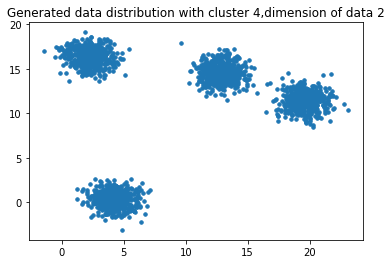

In [110]:
# Generating random dataset center at K cluster
def sample_data(num_cluster, dim_data, mean, std):
  
    
    center = np.random.random_sample((num_cluster, dim_data))*std + mean
    data = center
    for i in range(num_cluster):
      
        temp = np.random.randn(500, dim_data) + center[i]  # 500 points in each cluster.
        data = np.concatenate((data,temp), axis=0)
        
    return data

num_cluster = 4                       # Number of cluster
dim_data = 2                          # Dimension of Data.
mean = 0                              # Mean of distribution
std = 20                              # Deviation of Data distribution from mean.

data = sample_data(num_cluster, dim_data, mean, std)
plt.scatter(data[:, 0], data[:, 1], s = 12)
plt.title('Generated data distribution with cluster {},dimension of data {}'.format(num_cluster, dim_data))

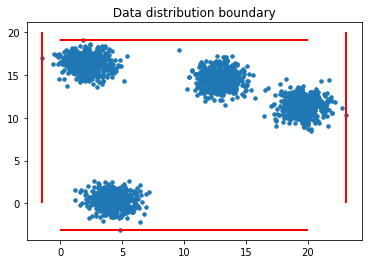

In [111]:
def data_boundary(X):
  """
    Returns the boundary of dataset, so that we can initilize random centeroids
    within data distribution.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a n-dimensional data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    Returns
    -------
    boundary : array_like
        A matrix of size (n,2), return max and min value along each dimension.
    
    """
  xy_min = np.amin(X, axis = 0)
  xy_max = np.amax(X, axis = 0)
  
  return np.array(xy_min)[np.newaxis,:], np.array(xy_max)[np.newaxis, :]

xy_min, xy_max = data_boundary(data)
x_min, y_min = xy_min[0][0], xy_min[0][1]
x_max, y_max = xy_max[0][0], xy_max[0][1]

#ax.hlines(y=0.2, xmin=4, xmax=20, linewidth=2, color='r')
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s = 12)
ax.hlines(y=y_min, xmin = mean, xmax = std, linewidth=2, color='r')
ax.hlines(y=y_max, xmin = mean, xmax = std, linewidth=2, color='r')
ax.vlines(x = x_min, ymin = mean, ymax = std, linewidth=2, color='r')
ax.vlines(x = x_max, ymin = mean, ymax = std, linewidth=2, color='r')
ax.set_title(" Data distribution boundary ")


plt.show()


### 3. Kmeans from scratch

In [0]:

def findClosestCentroid(X, centroids):
  
  """
  calculate the nearest centroids for each example in our dataset.

  Parameters
  ----------
  X : array_like
     The datset where each row is a n-dimensional data point. That is, it 
     is a matrix of size (m, n) where there are m datapoints each
     having n dimensions.
  centroids : array_like
     The k-means centroids of size (K, n). K is the number
     of clusters, and n is the the data dimension.
  Returns
  -------
  clusters : array_like
      A vector of size (m,), return the cluster assign to each example in dataset.
  """
  
  k = centroids.shape[0]
  clusters = np.zeros(X.shape[0])
  for i in range(X.shape[0]):
      dist = []
      for j in range(k):
        dist.append(euclidean_dist(X[i, :], centroids[j, :])) 
      clusters[i] = np.argmin(dist)
      
  return clusters


def computeCentroids(X, idx, k):

  """
  Returns the new centroids by computing the means of the data points
  assigned to each centroid.

  Parameters
  ----------
  X : array_like
     The datset where each row is a n-dimensional data point. That is, it 
     is a matrix of size (m, n) where there are m datapoints each
     having n dimensions.

  idx : array_like 
      A vector(int) of centroid assignments for each example.

  K : int
      Number of clusters

  Returns
  -------
  centroids : array_like
      A matrix of size (k, n) where each row is the mean of the data 
      points assigned to it.

  """
  
  m, n = X.shape
  new_centroids = np.zeros((k, n))
  for i in range(k):
    points = [np.asarray(X[j]) for j in range(X.shape[0]) if idx[j] == i]
    if points:
        new_centroids[i] = np.mean(points, axis = 0)
  return new_centroids

def initialCentroids(X, k):
  """
  Return the initial centeroids within the data boundary
  
  Parameters
   ----------
   X : array_like
       The datset where each row is a n-dimensional data point. That is, it 
       is a matrix of size (m, n) where there are m datapoints each
       having n dimensions.
       
   Returns
    -------
    centroids : array_like
        A matrix of size (k, n) where each row is randomly generated 
        withing boundary.
  
  """
  
  X = np.array(X)
  m, n = X.shape # n = data dimentsion
  centroids = np.zeros((k, n))
  xy_min, xy_max = data_boundary(X)
  
  for i in range(k):
      for j in range(n):
          centroids[i,j] = xy_min[:, j] + np.random.random() * (xy_max[:, j] - xy_min[:, j]+1)
  return centroids

def euclidean_dist(x, y):
  """
  Compute the euclidean distance between two points.
  
  Parameters
   ----------
   x : array_like
       a vector of n-dimensional points(equal dimention with centroid dimension.
       
   y : array_like
       a vector of n-dimensional points(same dimension as x)
       
   Returns
    -------
   dist : float
        return euclidean distance of two vectors.
  
  """
  
  
  dist = 0
  for i in range(x.shape[0]):
    dist += (x[i]-y[i])**2 
    
  return np.sqrt(dist)



def centroid_diff(curr_center, prev_center):
  
  """
  Compute the difference between current centroids and previous centroids.
  
  Parameters
   ----------
   curr_center : array_like
       a vector of n-dimensional points(equal dimention with centroid dimension.
       
   prev_center : array_like
       a vector of n-dimensional points(same dimension as x)
       
   Returns
    -------
   diff : float
        return difference between centroids.
  
  """
  diff = 0
  for i in range(curr_center.shape[0]):
    diff += euclidean_dist(curr_center[i, :], prev_center[i, :])
  
  return diff


  
def kmeans_algorithm(X, k):
  """
  Runs the K-means algorithm.
  Parameters
  ----------
  X : array_like
      The data set of size (m, n). Each row of X is a single example of n dimensions. The
      data set is a total of m examples.
  k : int
      Number of clusters.

  Returns
  -------
  centroids : array_like
      A matrix of size (k, n), final updated centroids
  idx : array_like
      A vector of size (m,) for cluster assignment for each example in the dataset.
  idx_history : array_like
      A vector of idx for each update of centroids
  centroid_history : array_like
      A vector of cetroids for each update of centroids
   """

  X = np.array(X)
  
  m, n = X.shape # m: number of example, n: data dimension
  
  iteration_count = 0
  idx = None
  idx_history = []
  centroid_history = []
  
  # initialize centroids
  centroids = initialCentroids(X, k)
  prev_centroid = np.zeros(centroids.shape)
  
  # compute difference bw centroids
  update_diff = centroid_diff(centroids, prev_centroid)
  
  while update_diff != 0: # algorithm stoping criteria
    
    # assign each example to some cluster
    idx = findClosestCentroid(X, centroids) 
    # for data visulaization
    idx_history.append(idx)
    centroid_history.append(centroids)
    # compute new centroid location   
    prev_centroid = centroids
    centroids = computeCentroids(X, idx, k)
    iteration_count += 1
    update_diff = centroid_diff(centroids, prev_centroid)
    
  return centroids, idx, idx_history, centroid_history, iteration_count


In [0]:
centroids, idx, idx_history, centroid_history, iteration_count = kmeans_algorithm(data, num_cluster)


### 4. Data Visualization


In [0]:
def plotProgresskMeans(i, X, centroid_history, idx_history):
    
    K = centroid_history[0].shape[0]
    pyplot.gcf().clf()
    cmap = pyplot.cm.rainbow
    norm = mpl.colors.Normalize(vmin=0, vmax=2)

    for k in range(K):
        current = np.stack([c[k, :] for c in centroid_history[:i+1]], axis=0)
        pyplot.plot(current[:, 0], current[:, 1],
                    '-Xk'
                   )

        pyplot.scatter(X[:, 0], X[:, 1],
                       c=idx_history[i],
                       cmap=cmap,
                       marker='o',
                       s=8**2,
                       linewidths=1,)
    pyplot.grid(False)
    pyplot.title('Iteration number %d' % (i+1))


def plot_intractive(X, centroids,idx, idx_history, centroid_history,
              max_iters):
  X = X
    
  fig = pyplot.figure()
  anim = FuncAnimation(fig, plotProgresskMeans,
                       frames=max_iters,
                       interval=250,
                       repeat_delay=0.01,
                       fargs=(X, centroid_history, idx_history))
  return anim



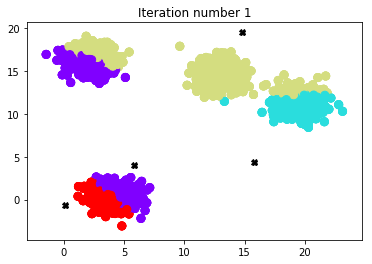

In [132]:
plot_intractive(data, centroids,idx, idx_history, centroid_history,
              max_iters=iteration_count)

Text(0.5, 1.0, 'After K-means')

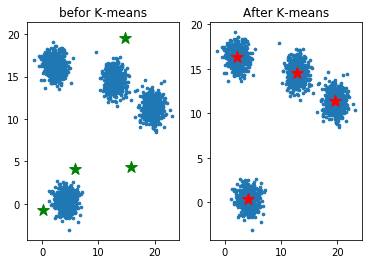

In [124]:
# Plot the data and the centers generated as random
plt.subplot(121)
plt.scatter(data[:,0], data[:,1], s=7)
plt.scatter(centroid_history[0][:,0], centroid_history[0][:,1], marker='*', c='g', s=150)
plt.title("befor K-means")
plt.subplot(122)
plt.scatter(data[:,0], data[:,1], s=7)
plt.scatter(centroid_history[-1][:, 0], centroid_history[-1][:, 1], marker="*", c = 'r', s = 150)
plt.title("After K-means")